In [2]:
import torch
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from utils.SSData import SSData
from models.REN import REN, t
import time

In [3]:
torch.set_default_dtype(torch.double)

In [4]:
def rollout(data_obj, c, phi, num_steps, num_traj=1, x0=None, get_traj=False):
    """
    Rolls out a system trajectory and computes the stage cost.
    data_obj is an SSData obj
    c is a stage cost function, that takes as input the output y, state x, and input u at each time step (batched tensors).
            returns a tensor cost of size (num_traj, 1, 1) (c must be differentiable)
    phi is a control policy that accepts the current output y_t and current policy state x_t (possibly None) and outputs u_t and next state x_{t+1}
    num_steps is the number of steps to be simulated, so that the duration of the trajectory is T=num_steps*dT, where dT is the discretization time.
    num_traj is the number of trajectories to simultaneously simulate (default 1)

    returns a tensor of costs of size (num_traj, num_steps, 1, 1)
    if get_traj is True, then returns
    cost (num_traj, num_steps, 1, 1), y (num_traj, num_steps, n_y, 1), x (num_traj, num_steps, n_x, 1), u (num_traj, num_steps, n_u, 1)
    """

    A, B, C, D = data_obj.getSSmatrices()
    
    # Extract dimensions
    n_x = data_obj.n_x
    n_u = data_obj.n_u
    n_y = data_obj.n_y

    # Pad x0 to fit n_x
    if x0 is not None and x0.size()[1] < n_x:
        x0 = torch.cat((x0, torch.zeros(num_traj, n_x-x0.size()[1], 1)), 1)

    x = x0 if x0 is not None else torch.zeros(num_traj, n_x, 1)
    x_phi = None
    
    cost = torch.zeros(num_traj, 1, 1) 
    
    cost_t = torch.zeros(num_steps, num_traj, 1, 1)

    # Start simulation...
    for t in range(num_steps):
        x_t = x

        # Compute current output y_t without input
        z_t = torch.matmul(C, x_t)

        u_t = None
        if phi is not None:
            # Compute input u_t for current output y_t
            u_t, x_phi = phi(z_t[:,:phi.n_u,:], x_phi, get_state=True)
        else:
            u_t = torch.zeros(num_traj,n_u,1)

        # Compute current output y_t
        z_t = torch.matmul(C, x_t) + torch.matmul(D, u_t)

        # Unpack
        # y_t = z_t[:,:n_x,:]
        # u_t = z_t[:,n_x:,:]
        
        # Incur in stage cost
        cost_t[t:t+1, :, :, :] = c(z_t)

        # Next state
        x_tp1 = torch.matmul(A, x_t) + torch.matmul(B, u_t)

        # Update variable
        x = x_tp1

    return torch.transpose(cost_t, 0, 1)
    

In [5]:
def stageCost(z_t):
    C = torch.diag(torch.tensor([10,0.1,10,0.1,0.01]))
    return torch.matmul(torch.matmul(torch.transpose(z_t,1,2), C), z_t)

In [6]:
nom_data = SSData('data/nominal.mat')
rob_data = SSData('data/robust.mat')

In [7]:
num_traj = 1000
x0 = torch.tensor(np.load('data/x0.npy')[0:num_traj,:,:])
x0.shape

torch.Size([1000, 4, 1])

In [8]:
roll_nom = rollout(nom_data, stageCost, None, 1000, num_traj=1000, x0=x0[0:num_traj,:,:])
roll_rob = rollout(rob_data, stageCost, None, 1000, num_traj=1000, x0=x0[0:num_traj,:,:])

In [9]:
roll_rob.size()

torch.Size([1000, 1000, 1, 1])

In [10]:
roll_nom_ = torch.transpose(roll_nom, 0,1).detach().numpy().squeeze()
roll_rob_ = torch.transpose(roll_rob, 0,1).detach().numpy().squeeze()

In [11]:
ts = nom_data.dT*np.arange(1000) #.reshape(-1,1).repeat(1000, axis=-1)

In [12]:
ts.shape

(1000,)

In [13]:
roll_nom_.shape

(1000, 1000)

In [14]:
upperb_nom = np.max(roll_nom_, axis=1, keepdims=True).squeeze()
lowerb_nom = np.min(roll_nom_, axis=1, keepdims=True).squeeze()
mean_nom = np.mean(roll_nom_, axis=1, keepdims=True).squeeze()

In [15]:
upperb_rob = np.max(roll_rob_, axis=1, keepdims=True).squeeze()
lowerb_rob = np.min(roll_rob_, axis=1, keepdims=True).squeeze()
mean_rob = np.mean(roll_rob_, axis=1, keepdims=True).squeeze()

In [16]:
upperb_nom.shape

(1000,)

Text(0.5, 1.0, 'Rollouts')

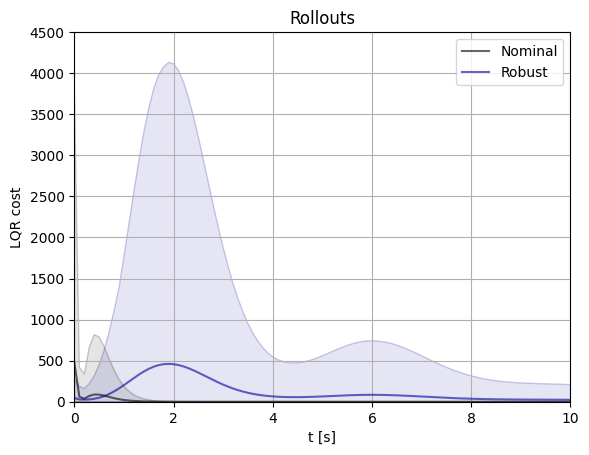

In [17]:
plt.fill_between(ts, lowerb_rob, upperb_rob, color=(0.0,0.0,0.6,0.1), edgecolor=(0.0,0.0,0.6,0.2))
plt.fill_between(ts, lowerb_nom, upperb_nom, color=(0.0,0.0,0.0,0.1), edgecolor=(0.0,0.0,0.0,0.2))
plt.plot(ts, mean_nom, color=(0.0,0.0,0.0,.6), label='Nominal')
plt.plot(ts, mean_rob, color=(0.0,0.0,0.6,.6), label='Robust')
plt.xlabel('t [s]')
plt.ylabel('LQR cost')
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,4500)
plt.title('Rollouts')

## Training

Load the robust IQC multiplier:

In [48]:
qsr_data = loadmat('data/QSR.mat')
Q = torch.tensor(qsr_data['Q'], dtype=torch.double)
S = t(torch.tensor(qsr_data['S'], dtype=torch.double))
R = torch.tensor(qsr_data['R'], dtype=torch.double)
Q = torch.tensor([[-1.0]])
S = torch.zeros_like(S)
R = torch.eye(4)
print("Q:")
print(Q.numpy())
print("S:")
print(S.numpy())
print("R:")
print(R.numpy())

Q:
[[-1.]]
S:
[[0. 0. 0. 0.]]
R:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Load initial conditions:

In [19]:
x0 = torch.tensor(np.load('data/x0.npy'))

In [57]:
phi = REN(n_x=40, n_units=500, n_y=1, n_u=4, Q=Q, S=S, R=R, bias=True, train_qsr=False)

In [41]:
with torch.no_grad():
    roll_robaug = rollout(rob_data, stageCost, phi, 1000, num_traj=50, x0=x0[0:50,:,:])

In [42]:
roll_robaug_ = torch.transpose(roll_robaug, 0,1).detach().numpy().squeeze()

In [43]:
upperb_robaug = np.max(roll_robaug_, axis=1, keepdims=True).squeeze()
lowerb_robaug = np.min(roll_robaug_, axis=1, keepdims=True).squeeze()
mean_robaug = np.mean(roll_robaug_, axis=1, keepdims=True).squeeze()

Text(0.5, 1.0, 'Rollouts')

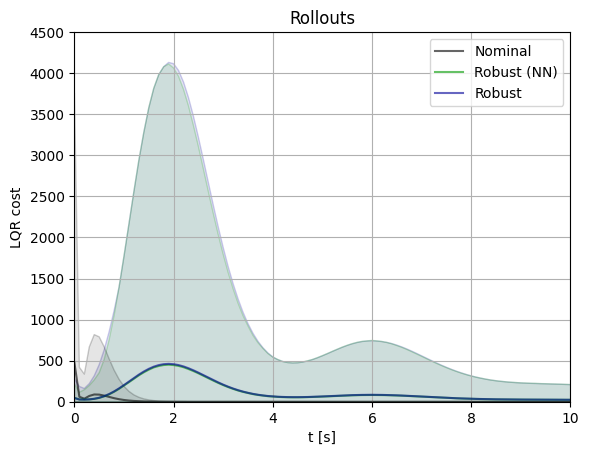

In [44]:
plt.fill_between(ts, lowerb_rob, upperb_rob, color=(0.0,0.0,0.6,0.1), edgecolor=(0.0,0.0,0.6,0.2))
plt.fill_between(ts, lowerb_robaug, upperb_robaug, color=(0.0,0.6,0.0,0.1), edgecolor=(0.0,0.6,0.0,0.2))
plt.fill_between(ts, lowerb_nom, upperb_nom, color=(0.0,0.0,0.0,0.1), edgecolor=(0.0,0.0,0.0,0.2))
plt.plot(ts, mean_nom, color=(0.0,0.0,0.0,.6), label='Nominal')
plt.plot(ts, mean_robaug, color=(0.0,0.6,0.0,.6), label='Robust (NN)')
plt.plot(ts, mean_rob, color=(0.0,0.0,0.6,.6), label='Robust')
plt.xlabel('t [s]')
plt.ylabel('LQR cost')
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,4500)
plt.title('Rollouts')

Train and compare performance again

In [58]:
learn_rate = 0.001
optim = torch.optim.Adam(phi.parameters(),learn_rate)

In [56]:
epochs = 100
name = 'Test3'

stats_train = [0 for i in range(epochs)]
stats_test = [0 for i in range(epochs)]

for epoch in range(epochs):

    print('Epoch {} of {}'.format(
        epoch+1,epochs
    ), flush=True)
    
    if (epoch) % 10 == 0:
        torch.save({'epoch': epoch,
                    'model_state_dict': phi.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'stats_train': stats_train,
                    'stats_test': stats_test,
                   }, 'saved_models\{}\{}.pt'.format(name, name+'-e'+str(epoch)))

    stime = time.time()
    
    # Reset gradient in optimizer
    optim.zero_grad(set_to_none=True)

    # Rollout trajectories with nonlinear control policy
    roll_train = rollout(rob_data, stageCost, phi, 100, num_traj=10, x0=x0[0:10,:,:])
    meanc = roll_train.mean()

    # Compute gradient and step optimizer
    meanc.backward()
    optim.step()
    phi.updateConstrainedWeights()

    etime = time.time()

    stats_train[epoch] = meanc.detach().item()

    print('    => mean train cost: {:.2f}'.format(
        meanc.detach().item()
    ))
    print('    => mean train time: {:.2f}s'.format(
        etime-stime
    ), flush=True)

    stime = time.time()
    with torch.no_grad():
        roll_test = rollout(rob_data, stageCost, phi, 100, num_traj=50, x0=x0[-50:,:,:])
        meanc_test = roll_test.mean().item()
        stats_test[epoch] = meanc_test
    etime = time.time()
    
    print('    => mean test cost: {:.2f}'.format(
        meanc_test
    ))
    print('    => mean test time: {:.2f}s'.format(
        etime-stime
    ), flush=True)

torch.save({'epoch': epoch,
            'model_state_dict': phi.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'stats_train': stats_train,
            'stats_test': stats_test,
           }, 'saved_models\{}\{}.pt'.format(name, name+'-e'+str(epoch)))

Epoch 1 of 100
    => mean train cost: 115.65
    => mean train time: 93.91s
    => mean test cost: 103.07
    => mean test time: 17.37s
Epoch 2 of 100
    => mean train cost: 115.86
    => mean train time: 101.81s
    => mean test cost: 103.56
    => mean test time: 17.54s
Epoch 3 of 100
    => mean train cost: 115.93
    => mean train time: 96.10s
    => mean test cost: 104.25
    => mean test time: 17.34s
Epoch 4 of 100
    => mean train cost: 115.94
    => mean train time: 94.23s
    => mean test cost: 105.01
    => mean test time: 17.35s
Epoch 5 of 100
    => mean train cost: 116.01
    => mean train time: 100.61s
    => mean test cost: 105.20
    => mean test time: 17.39s
Epoch 6 of 100
    => mean train cost: 116.07
    => mean train time: 101.99s
    => mean test cost: 105.41
    => mean test time: 17.41s
Epoch 7 of 100
    => mean train cost: 116.11
    => mean train time: 98.87s
    => mean test cost: 106.32
    => mean test time: 17.37s
Epoch 8 of 100
    => mean train cost:

KeyboardInterrupt: 

In [52]:
with torch.no_grad():
    roll_robaug = rollout(rob_data, stageCost, phi, 1000, num_traj=50, x0=x0[0:50,:,:])

In [53]:
roll_robaug_ = torch.transpose(roll_robaug, 0,1).detach().numpy().squeeze()

In [54]:
upperb_robaug = np.max(roll_robaug_, axis=1, keepdims=True).squeeze()
lowerb_robaug = np.min(roll_robaug_, axis=1, keepdims=True).squeeze()
mean_robaug = np.mean(roll_robaug_, axis=1, keepdims=True).squeeze()

Text(0.5, 1.0, 'Rollouts')

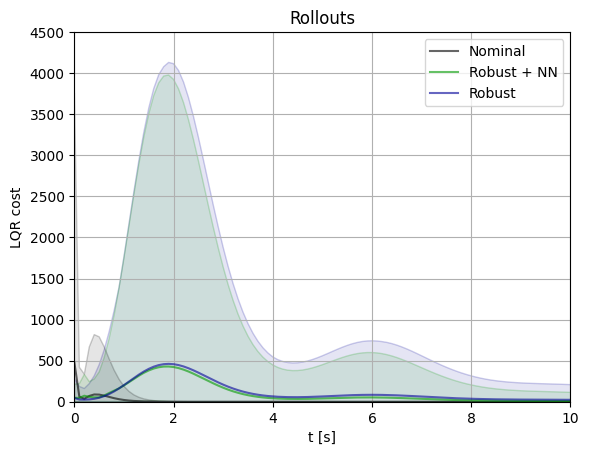

In [55]:
plt.fill_between(ts, lowerb_rob, upperb_rob, color=(0.0,0.0,0.6,0.1), edgecolor=(0.0,0.0,0.6,0.2))
plt.fill_between(ts, lowerb_robaug, upperb_robaug, color=(0.0,0.6,0.0,0.1), edgecolor=(0.0,0.6,0.0,0.2))
plt.fill_between(ts, lowerb_nom, upperb_nom, color=(0.0,0.0,0.0,0.1), edgecolor=(0.0,0.0,0.0,0.2))
plt.plot(ts, mean_nom, color=(0.0,0.0,0.0,.6), label='Nominal')
plt.plot(ts, mean_robaug, color=(0.0,0.6,0.0,.6), label='Robust + NN')
plt.plot(ts, mean_rob, color=(0.0,0.0,0.6,.6), label='Robust')
plt.xlabel('t [s]')
plt.ylabel('LQR cost')
plt.legend()
plt.grid(True)
plt.xlim(0,10)
plt.ylim(0,4500)
plt.title('Rollouts')